<a href="https://colab.research.google.com/github/201920973dldyddns/-/blob/main/F2_%EC%9D%B4%EC%9A%A9%EC%9A%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import fashion_mnist
import numpy as np

# 데이터셋 로드
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# 데이터 전처리
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

In [ ]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow as tf

latent_dim = 2  # 잠재 공간의 차원

# 인코더 정의
inputs = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)
z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

# 샘플링 레이어
def sampling(args):
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.keras.backend.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# 디코더 정의
latent_inputs = layers.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
decoder = Model(latent_inputs, outputs, name='decoder')
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# 손실 함수 정의
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [ ]:
vae.fit(x_train, epochs=50, batch_size=128, validation_data=(x_test, None))


1/1 [==============================] - 0s 132ms/step


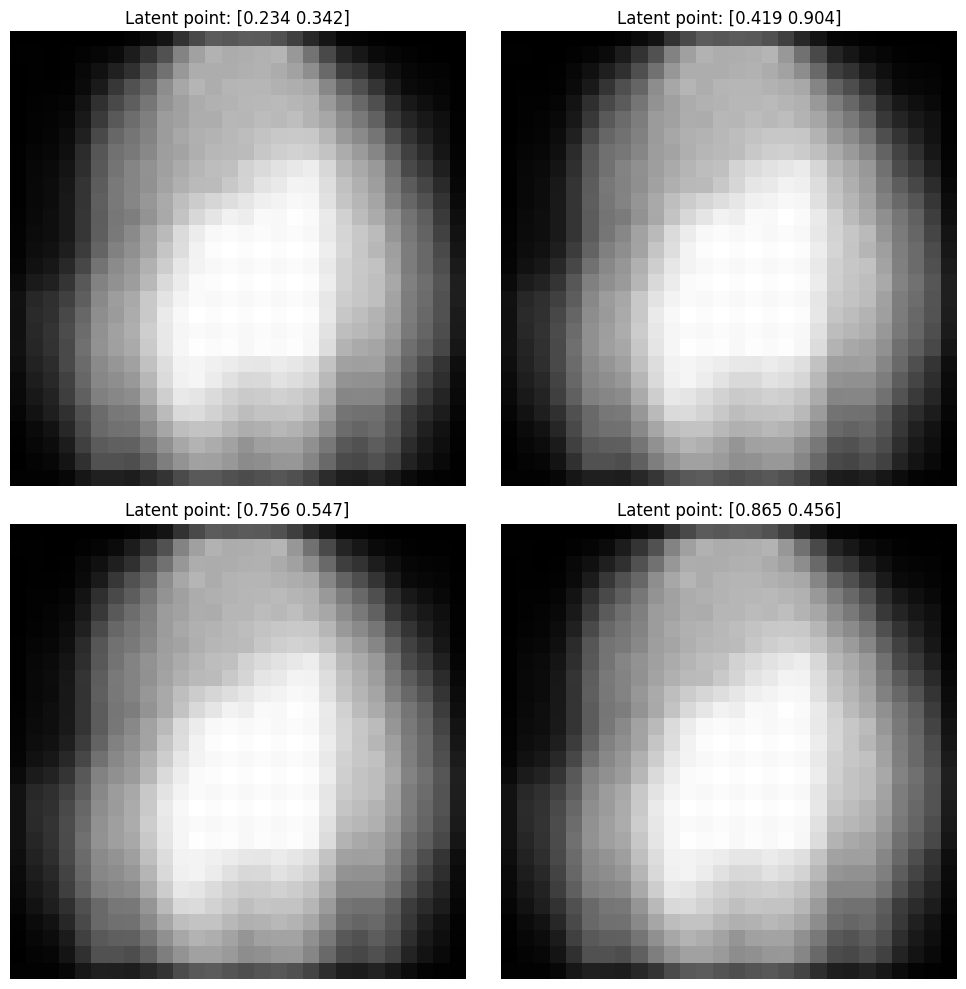

In [3]:
import matplotlib.pyplot as plt

# 잠재 공간에서 이미지 생성
latent_points = np.array([[0.234, 0.342], [0.419, 0.904], [0.756, 0.547], [0.865, 0.456]])
generated_images = decoder.predict(latent_points)

# 생성된 이미지 시각화
plt.figure(figsize=(10, 10))
for i in range(generated_images.shape[0]):
    plt.subplot(2, 2, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.title(f"Latent point: {latent_points[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
